Loaded glmnet 3.0-1

Parsed with column specification:
cols(
  Date = col_character(),
  Hour = col_time(format = ""),
  `Consumption (MWh)` = col_number()
)
Parsed with column specification:
cols(
  Date = col_character(),
  Hour = col_time(format = ""),
  `Consumption (MWh)` = col_number()
)


       Lag48   Lag168
1   4.717794 2.788572
2   4.840283 2.722898
3   5.075457 2.811951
4   5.116429 2.821935
5   5.167937 2.804456
6   5.363577 2.729042
7   5.932481 3.214715
8   7.986267 4.185707
9  11.946170 3.569413
10 12.236409 3.618641
11 11.117397 3.758849
12 10.796277 3.842628
13  9.453929 4.011883
14  9.819498 4.168138
15 11.715366 4.427675
16 11.451022 4.248038
17 10.859914 3.715162
18  9.002623 3.319667
19  6.049092 2.780434
20  4.835071 2.507765
21  4.665133 2.676206
22  4.380837 2.649428
23  4.280421 2.879376
24  4.692253 3.242937
          b
1  2.484539
2  2.425999
3  2.548167
4  2.577194
5  2.717250
6  2.812962
7  3.274448
8  4.310304
9  5.905244
10 6.312213
11 5.893385
12 5.901102
13 5.629229
14 5.871933
15 6.637634
16 6.393565
17 5.746888
18 4.864019
19 3.570785
20 2.920068
21 2.810574
22 2.648167
23 2.614924
24 2.899634
          c
1  3.083466
2  3.183196
3  3.326937
4  3.346951
5  3.353527
6  3.214679
7  3.756625
8  4.413482
9  4.899637
10 5.247464
11 5.294794
12 5.5

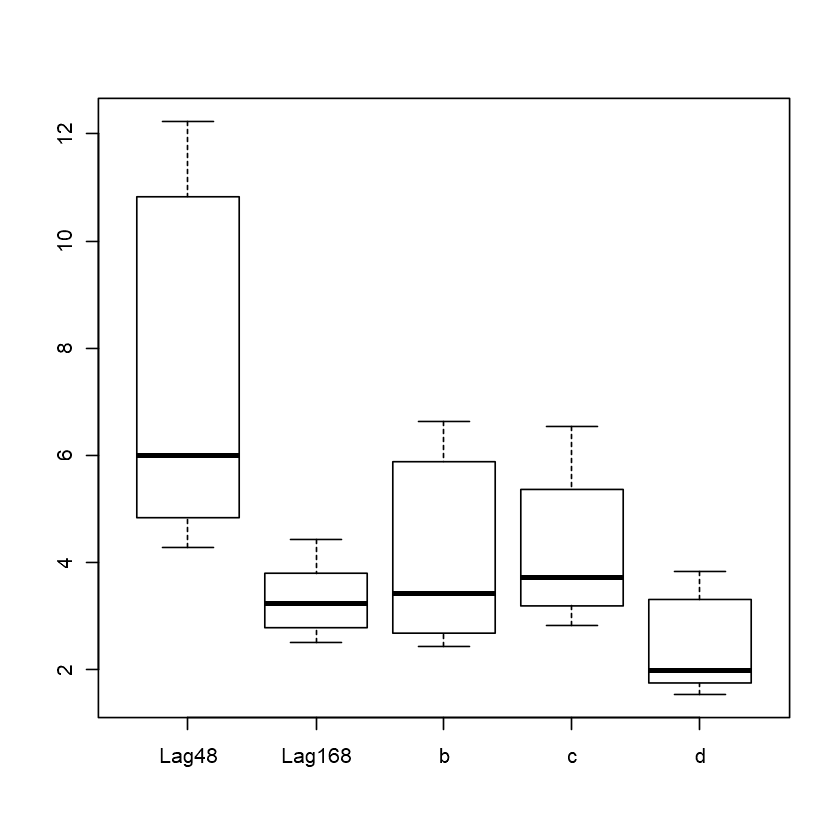

In [1]:
rm(list=ls()) 

library('codetools')
library('Matrix')
library('glmnet')
library('readr')
consumption_train <- read_csv(file="C:/Users/Onur/Desktop/IE 582/HW 3/RealTimeConsumption-01012016-31102019.csv", col_names=TRUE, col_types = NULL ) 
consumption_test <- read_csv(file="C:/Users/Onur/Desktop/IE 582/HW 3/RealTimeConsumption-01112019-19112019.csv", col_names=TRUE, col_types = NULL ) 

# First two weeks of November 2019 are chosen to be test set.

test_length <- 2*7*24
consumption_test <- consumption_test[1:test_length,,]

#####################################################
# Task 1 ############################################
#####################################################

lag48_prediction <- data.frame(Lag48 = matrix(0,test_length,1))
lag168_prediction <- data.frame(Lag168 = matrix(0,test_length,1))

task1_train = consumption_train

for(i in 1:test_length) {

  lag48_prediction$Lag48[i] <- task1_train$`Consumption (MWh)`[(length(task1_train$`Consumption (MWh)`)-47)]
  lag168_prediction$Lag168[i] <- task1_train$`Consumption (MWh)`[(length(task1_train$`Consumption (MWh)`)-167)]

  task1_train = rbind(task1_train,consumption_test[i,,])  
}

task1_test_and_predictions = cbind(consumption_test,lag48_prediction,lag168_prediction)
task1_errors = data.frame("Lag48.abs.errors" = abs(task1_test_and_predictions$`Consumption (MWh)`- task1_test_and_predictions$Lag48)/task1_test_and_predictions$`Consumption (MWh)` 
             , "Lag168.abs.errors" = abs(task1_test_and_predictions$`Consumption (MWh)`- task1_test_and_predictions$Lag168)/ task1_test_and_predictions$`Consumption (MWh)` )

task1_Lag48 =  rowSums(matrix(task1_errors$Lag48.abs.errors,24,14)) * 100 / 14
task1_Lag168 = rowSums(matrix(task1_errors$Lag168.abs.errors,24,14)) * 100 / 14

task1_MAPE = data.frame("Lag48" = task1_Lag48, "Lag168" = task1_Lag168) 

print(task1_MAPE)
#####################################################
# Task 2 ############################################
#####################################################

task2_train = consumption_train[169:length(consumption_train$Date),,]
task2_train = data.frame(task2_train, "Lag48" = consumption_train$`Consumption (MWh)`[(169-48):(length(consumption_train$Date)-48)]
              , "Lag168" = consumption_train$`Consumption (MWh)`[(169-168):(length(consumption_train$Date)-168) ] )

linear_model = lm(Consumption..MWh. ~ Lag48 + Lag168, task2_train)
task2_prediction <- matrix(predict(linear_model, task1_test_and_predictions),24,14)

task2_abs_prediction_error = abs(consumption_test$`Consumption (MWh)`- task2_prediction)/consumption_test$`Consumption (MWh)`
task2_MAPE = data.frame("b" = (rowSums(matrix(task2_abs_prediction_error,24,14))) * 100 / 14 )

print(task2_MAPE)
#####################################################
# Task 3 ############################################
#####################################################

task3_train = task2_train
task3_consumption = matrix(task3_train$Consumption..MWh.,24,length(task3_train$Lag48)/24)
task3_Lag48 = matrix(task3_train$Lag48,24,length(task3_train$Lag48)/24)
task3_Lag168 = matrix(task3_train$Lag168,24,length(task3_train$Lag48)/24)
task3_coefficients = matrix(0,24,3)

for(i in 1:24) {
  
  temp_train = data.frame("Consumption..MWh." = task3_consumption[i,],"Lag48"=task3_Lag48[i,], "Lag168"=task3_Lag168[i,])
  task3_lm = lm(Consumption..MWh. ~ Lag48 + Lag168, temp_train)
  task3_coefficients[i,] = task3_lm$coefficients 
  
}

task3_prediction = matrix(0,336,1)

for(i in 0:13){
  
  task3_prediction[(i*24+1):(i*24+24),1] = task3_coefficients[,1] + task3_coefficients[,2]*task1_test_and_predictions[(i*24+1):(i*24+24),4] + task3_coefficients[,3]*task1_test_and_predictions[(i*24+1):(i*24+24),5]
  
}

task3_abs_prediction_error = abs(consumption_test$`Consumption (MWh)`- task3_prediction)/consumption_test$`Consumption (MWh)`
task3_MAPE = data.frame("c" = (rowSums(matrix(task3_abs_prediction_error,24,14))) * 100 / 14 )

print(task3_MAPE)
#####################################################
# Task 4 ############################################
#####################################################

task4_train = data.frame(t(task3_Lag48),t(task3_Lag168),t(task3_consumption))
task4_test = data.frame(t(matrix(task1_test_and_predictions$Lag48,24,14)),t(matrix(task1_test_and_predictions$Lag168,24,14))) 
task4_predict = matrix(0,14,24)
set.seed(1000)

for(i in 1:24) {
  
  cvfit = cv.glmnet(as.matrix(task4_train[1:NROW(task4_train),1:48]), as.matrix(task4_train[1:NROW(task4_train),48+i]))
  
  for(j in 1:14) {
    
    task4_predict[j,i] = predict(cvfit, as.matrix(task4_test[j,]), s = "lambda.min")
    
  }
}

task4_predict = t(task4_predict)
task4_predict = data.frame("Task4" = as.vector(task4_predict))

task4_abs_prediction_error = abs(consumption_test$`Consumption (MWh)`- task4_predict)/consumption_test$`Consumption (MWh)` 
task4_MAPE = data.frame("d" = (rowSums(matrix(as.matrix(task4_abs_prediction_error),24,14))) * 100 / 14 )

# plot(cvfit, xvar = "lambda", label = TRUE)

print(task4_MAPE)

print("coefficients of the last models shows that b0 is the most important coefficient")
print("some of the coefficients shrink to zero")
print("Among the nonzero coefficients, largest coefficient is X24, which is meaningful because this is model 
      of last hour in a day \n")
print(coef(cvfit,s = "lambda.min"))

#####################################################
# Task 5 ############################################
#####################################################

all_results = data.frame(task1_MAPE,task2_MAPE,task3_MAPE,task4_MAPE)

boxplot(all_results)

print("\n box plot shows that Lasso is a very effective method for time series")
print("Among all models, lasso gives the best results whereas lag 48 is the worst at the test data")
print("Both linear models give similar performances but building 24 models seperately seems more robust ")
print("lag 168 is the second best method. it gives good results and it is quite robust ")